In [81]:
# Title: RiverStone Assignment
# Author: Tadhg Lynch
# Date: 2023-4-14

#packages
import pandas as pd

In [83]:
#import data
df = pd.read_csv("data/reddit_worldnews_start_to_2016-11-22.csv")

# data description from kaggle

# Reddit is a social network which divide topics into so called 'subreddits'.
# In subreddit 'worldnews', news of the whole world are published. The dataset contains following columns:
# time_created - a Unix timestamp of the submission creation date
# date_created - creation time in %Y-%m-%d
# up_votes - how often the submission was upvoted
# down_votes - how often the submission was downvoted
# title - the title of the submission
# over_18 - if the submission is for mature persons
# author - the reddit username of the author
# subreddit - this is always 'worldnews'

df.info() # non-nulls across the board, nice

# I like to see the data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   subreddit     509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


# Request 1
Description: Build and graph a seasonal index of average upvotes by post at the Monthly, Day of Week, and Hour of  Day levels. 

In [84]:
# converting unix timestamp as will be needed for hourly
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')

# check that new time_created matches date_created
matching = df['time_created'].dt.date == pd.to_datetime(df['date_created']).dt.date

# show df columns where matching is false
df[matching == False]


# This singular mismatched case has been caused by a post being created at exactly midnight, so will be sticking with the converted unix timestamp
# despite not being shown, it has time of 00:00:00, so will be fine for hourly

# drop no longer needed date_created column
df = df.drop(['date_created'], axis=1)

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
343260,2015-02-10,2015-02-09,7,0,Christians in India want their own Christian c...,False,InternetOfficer,worldnews


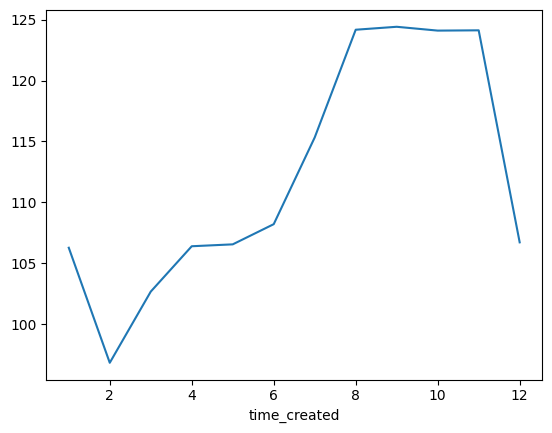

In [146]:
# Function to graph seasonal index
def graph_seasonal_index(df, level):
    # group by level
    df_grouped = df.groupby(level)['up_votes'].mean()

    # graph seasonal index
    df_grouped.plot()


graph_seasonal_index(df, df['time_created'].dt.month)

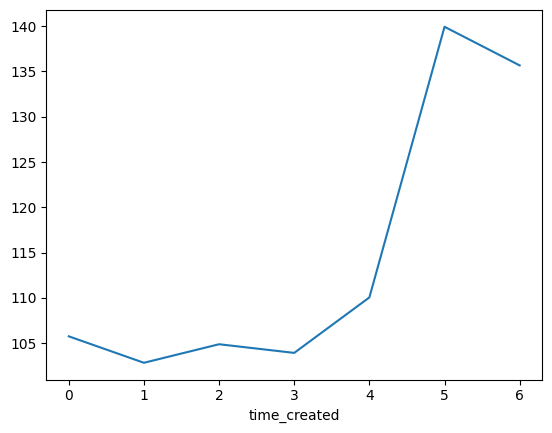

In [147]:
graph_seasonal_index(df, df['time_created'].dt.dayofweek)

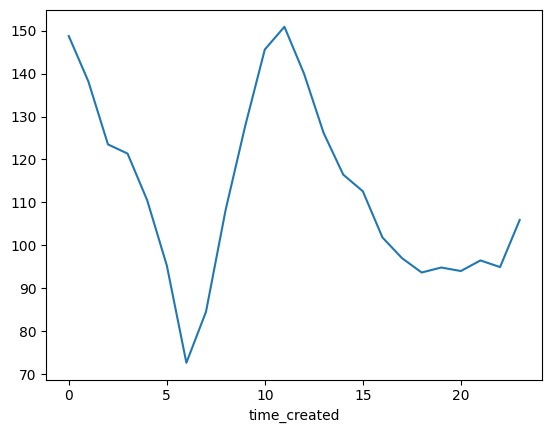

In [148]:
graph_seasonal_index(df, df['time_created'].dt.hour)

# Request 2
Clean, scrub, and prepare post titles using standard NLP techniques. 

In [163]:
# The Subreddit posted rules:
# 1. No US Internal News or Politics
# 2. No Editorialized or Misleading Titles
# 3. No Feature stories
# 4. No Editorials, Opinion or Analysis Pieces
# 5. No Articles In Languages Other Than English
# 6. No Images, Videos or Audio Clips
# 7. No Bigotry or Other Offensive Content
# 8. No Personal Attacks On Other Users
# 9. No Memes, Gifs, unlabeled NSFW images
# 10. No Old News Articles (≥ 1 Week old)

# Main NLP Takeaways:
# no sentiment
# no other languages 
# unlikely to have poor grammar or misspellings (inferred by strict moderators)
# no emojis

# NLP ideas:
# Lots on Russia invasion of Ukraine, look out of more sparse references (e.g. Crimea, Moscow, Putin, etc.)... nevermind, dataset only goes up to 2016-11-22

In [151]:
# function to clean, scrub, and prepare post title using standard NLP techniques
def clean_post_title(post_title):
    # convert to lowercase
    post_title = post_title.lower()
    # remove numbers
    post_title = ''.join([i for i in post_title if not i.isdigit()])
    # remove single characters
    post_title = ' '.join([word for word in post_title.split() if len(word) > 1])
    # remove extra whitespace
    post_title = ' '.join(post_title.split())
    return post_title

clean_titles = df['title'].apply(clean_post_title)

# would apply more cleaning techniques, but OpenAI's models take care of this for us; in fact think what has been removed already may not be optimal as the model is designed to handle natural writing, so jumping to Request 3 and seeing how it goes before returning to this.

# Request 3
Cluster post titles and identify the top 20 clusters by frequency. Use of Chat-GPT AI is encouraged. 

In [1]:
# !pip install openai
!pip install curl


ERROR: Could not find a version that satisfies the requirement curl (from versions: none)
ERROR: No matching distribution found for curl


In [169]:
curl https://api.openai.com/v1/embeddings \
  -H "Content-Type: application/json" \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -d '{
    "input": "Your text string goes here",
    "model": "text-embedding-ada-002"
  }'

SyntaxError: unterminated string literal (detected at line 4) (2940115770.py, line 4)

In [170]:
import curl

ModuleNotFoundError: No module named 'curl'